# Kinetics Project Validation Tool
## This notebook can be used to validate a model against experimental data
The following is the isothermal reaction under investigation:
$\require{mhchem}$
$$\ce{A ->[C] D + U}$$

where A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.
We can control the starting concentration of A, the concentration of C, and the reaction temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
%matplotlib inline

## Use the following cell to import tab-separated experiment data

In [2]:
filename = "data/exp1426.tsv"
exp = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=2, names=['Time', 'A', 'D', 'U'])
init = pd.read_csv(filename, sep="\t|[ ]{1,}", engine='python', skiprows=1, names=['A', 'D', 'U', 'C', 'T'], nrows=1, usecols=range(2, 7))
t_final = exp.Time.values[-1]
t_prefinal = exp.Time.values[-2]

## We propose the following mechanism
$\require{mhchem}$
$$\ce{\alpha_1 A + \gamma C->[k_1] \beta B + \gamma C}$$

$$\ce{\alpha_2 A ->[k_2] \epsilon_1 E}$$

$$\ce{\epsilon_2 E <=>[{k_3}][{k_{-3}}] \upsilon U}$$

$$\ce{\beta B <=>[{k_4}][{k_{-4}}] \delta D}$$


A is the starting reagent, C is the catalyst, D is the desired product, and U is the undesired product.

The following rate laws will be tested.

$$-r_A = k_1 C_A^{\alpha_1} C_C^{\gamma} + k_2 C_A^{\alpha_2} + k_4 C_A^{\alpha_3}$$

$$r_U = k_2 C_A^{\alpha_2} + k_4 C_A^{\alpha_3}$$

$$r_B = k_1 C_A^{\alpha_1} C_C^{\gamma} + k_{-3} C_D^{\delta} - k_3 C_B^{\beta}$$

$$r_D = k_3 C_B^\beta - k_{-3} C_D^\delta$$

Applying the pseudo steady-state hypothesis on the intermediate species B and adding the last two equations, we obtain the following relation.

$$r_D = k_1 C_A^{\alpha_1} C_C^{\gamma}.$$

Therefore,

$$-r_A = r_D + r_U$$

## Use the cell below to enter a rate law. Define all necessary constants

In [3]:
def dadt(cA, cB, alpha, beta1, k1, k_1):
    return k_1 * cB**beta1 - k1 * cA**alpha
    
def dudt(cB, beta3, k3):
    return k3 * cB**beta3

def dddt(cB, cC, beta2, gamma, k2):
    return k2 * cB**beta2 * cC**gamma

def concentrations(cA0, cC0, T, time, params):
    """"
    This function calculates the concentrations of the reacting species using a proposed rate law
    cA (mol/L) is the initial concentration of reactant A
    cC (mol/L) is the initial catalyst concentration
    T (K) is the temperature
    time (s) is the elapsed reaction time
    Return values:
    time (s) array of times at which concentrations were calculated
    cA (mol/L) array of concentrations of A during the time interval
    cD (mol/L) array of concentrations of the desired product D during the time interval
    cU (mol/L) array of concentrations of the undesired product U during the time interval
    """
    
    try:
        alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3 = params
    except:
        print("Params should contain at least 9 parameters!")
        return -1, -1, -1, -1,
    else:                
        def rates(parms, time):
            """
            Returns the RHS of the system of ODEs
            """
            C_A, C_B, C_D, C_U = parms
            rateD = dddt(C_B, cC0, beta2, k1, k_1)
            rateU = dudt(C_B, beta3, k3)
            rateA = dadt(C_A, C_B, alpha, beta1, k1, k_1)
            rateB = -1 * (rateA + rateD + rateU)
            return (rateA, rateB, rateD, rateU)
        
        times = np.linspace(0, time, 100)
        
        result = odeint(rates, (cA0, 0., 0., 0.), times)
        
        cA = result[:,0]
        cB = result[:,1]
        cD = result[:,2]
        cU = result[:,3]
        
    return times, cA, cD, cU, cB

## Integrate
Use the cell below to carry out the integration

In [4]:
alpha = 3. # 3
beta1 = 2. # 2
beta2 = 2. # 2
beta3 = 2. # 2
gamma = 1. # 1
k1 = 4. # 2.2
k_1 = 1.5 # 1.6
k2 = 1. # 1
k3 = 0.2 # 0.38
times, A, D, U, B = concentrations(init.A, init.C, init.T, t_prefinal,
                                (alpha, beta1, beta2, beta3, gamma, k1, k_1, k2, k3))

## Plot
Plot the results of the calculation.

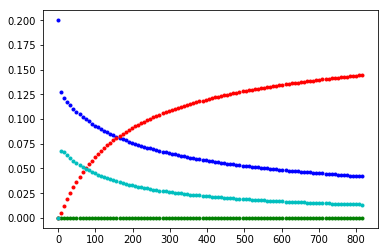

In [5]:
plt.plot(times, A, 'b.',
       times, D, 'g.',
       times, U, 'r.',
       times, B, 'c.')

## Compare
Compare to the experimental results below.

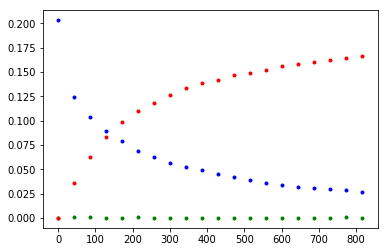

In [6]:
plt.plot(exp.Time.values[:-1], exp.A.values[:-1], 'b.',
       exp.Time.values[:-1], exp.D.values[:-1], 'g.',
       exp.Time.values[:-1], exp.U.values[:-1], 'r.')

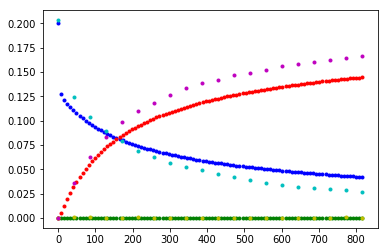

In [7]:
# Plot experimental and calculated results on the same chart
plt.plot(times, A, 'b.',
       times, D, 'g.',
       times, U, 'r.',
       exp.Time.values[:-1], exp.A.values[:-1], 'c.',
       exp.Time.values[:-1], exp.D.values[:-1], 'y.',
       exp.Time.values[:-1], exp.U.values[:-1], 'm.')

## Parameters of interest

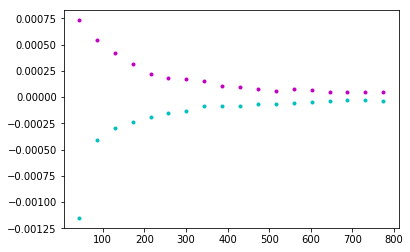

In [8]:
# 3-point differentiation of experimental [A] and [U]
exp_a = exp.A.values[:-1] # ignore the last long-time value
exp_u = exp.U.values[:-1] # ignore the last long-time value
exp_t = exp.Time.values[:-1] # ignore the last long-time value
delta_t = exp_t[1] - exp_t[0]
exp_ra = (np.diff(exp_a[:-1]) + np.diff(exp_a[1:])) / (2 * delta_t)
exp_ru = (np.diff(exp_u[:-1]) + np.diff(exp_u[1:])) / (2 * delta_t)

plt.plot(exp_t[1:-1], exp_ru, 'm.', exp_t[1:-1], exp_ra, 'c.')

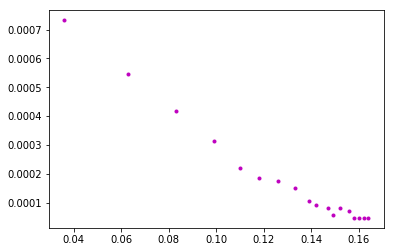

In [9]:
plt.plot(exp_u[1:-1], exp_ru, 'm.')

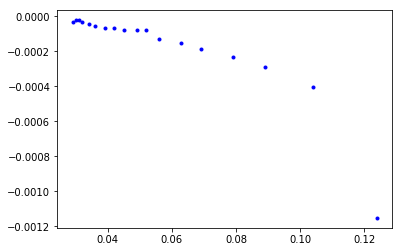

In [10]:
plt.plot(exp_a[1:-1], exp_ra, 'b.')